Pairs trading involves picking two stocks that are related in some way and profiting from the pricing differences between them. 

In [21]:
import math
import numpy as np
import matplotlib.pyplot  as plt
import yfinance as yf
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

tickers = [
    "KO", "PEP",
    "K", "GIS",
    "CPB", "KHC",
    "MDLZ", "HSY",
    "SJM", "KMB",
    "PG", "CL",
    "WMT", "COST",
    "TGT"
]
data = yf.download(tickers, start='2022-01-01', end='2025-01-01')

prices = data['Close']

print(prices)

/tmp/ipykernel_2073/3117712532.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2022-01-01', end='2025-01-01')
[*********************100%***********************]  15 of 15 completed


Ticker             CL        COST        CPB        GIS         HSY  \
Date                                                                  
2022-01-03  76.912781  540.298584  38.054550  58.529987  175.015472   
2022-01-04  77.167374  537.934204  38.385159  59.078213  176.510101   
2022-01-05  77.485619  524.291016  38.850166  59.870094  178.448563   
2022-01-06  76.976448  524.176514  39.508198  59.600353  178.059082   
2022-01-07  76.776405  511.191345  40.227646  60.117615  177.406891   
...               ...         ...        ...        ...         ...   
2024-12-24  90.208801  953.842712  39.853218  60.951344  165.077072   
2024-12-26  90.189278  951.176636  39.929787  60.970459  164.776886   
2024-12-27  89.642494  934.821960  40.015926  61.152149  166.306747   
2024-12-30  88.646584  917.422791  39.642658  60.597523  163.314865   
2024-12-31  88.763756  911.513611  40.082924  60.980022  163.973282   

Ticker              K        KHC         KMB         KO       MDLZ  \
Date  

[('KHC', 'TGT'), ('KMB', 'KO')]


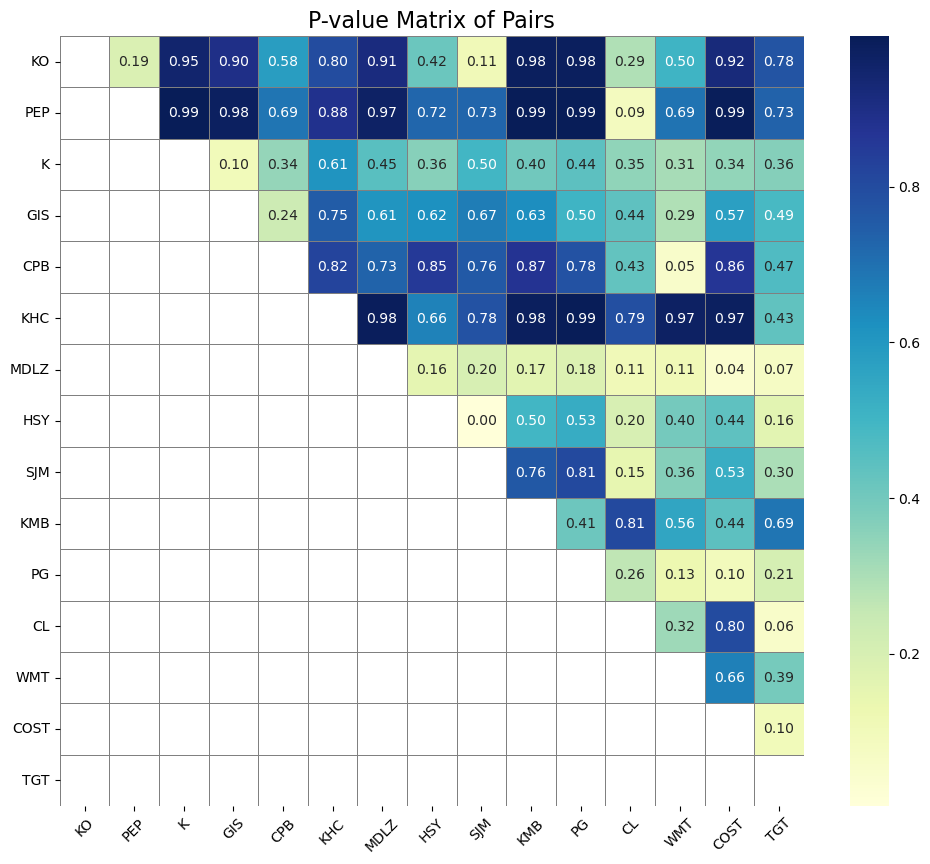

In [2]:
# start by running a cointegration test between chosen list of stocks/securities

def find_cointegrated_pairs(data):
    n = data.shape[1]
    # print(n)
    keys = data.keys()
    # print(keys)
    pvalue_matrix = np.ones((n, n))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            coint_val, p_val, _ = coint(s1, s2)
            pvalue_matrix[i, j] = p_val
            if p_val < 0.05:
                pairs.append((keys[i], keys[j]))
    return pairs, pvalue_matrix
    

res, pvalue_matrix = find_cointegrated_pairs(prices)
print(res)

def plot_p_val_matrix(p_val_matrix, tickers):
    # Make a mask for the upper triangle
    mask = np.tril(np.ones_like(p_val_matrix, dtype=bool))
    
    plt.figure(figsize=(12,10))
    
    # Custom colormap: yellow → green → blue
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    
    sns.heatmap(
        p_val_matrix,
        mask=mask,               # mask upper triangle
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar=True,
        xticklabels=tickers,
        yticklabels=tickers,
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title("P-value Matrix of Pairs", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_p_val_matrix(pvalue_matrix, tickers)

In [8]:
# stationarity test
def stationarity_test(x, cutoff=0.05):
    # H_0: non stationarity
    # H_1: low enough p val for stationarity
    pvalue = adfuller(x)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + x.name +' is likely stationary.')
        return True
    print('p-value = ' + str(pvalue) + ' The series ' + x.name +' is likely non-stationary.')
    return False
        
        

# get stocks that are cointegrated and add them all to a set:

def test_stationarity_on_cointegrated_pairs(coint_pairs, data):
    res = []
    for coint_pair in coint_pairs:
        s1 = data[coint_pair[0]]
        s2 = data[coint_pair[1]]
        is_stationary_s1 = stationarity_test(s1)
        is_stationary_s2 = stationarity_test(s2)
        print()
        if is_stationary_s1 and is_stationary_s2:
            res.append(coint_pair[0])
            res.append(coint_pair[1])
    return res


valid_pairs = test_stationarity_on_cointegrated_pairs(res, prices)
print(valid_pairs)
        

p-value = 0.04178527228415809 The series KHC is likely stationary.
p-value = 0.036572960967202396 The series TGT is likely stationary.

p-value = 0.23019186052207807 The series KMB is likely non-stationary.
p-value = 0.2859447603966424 The series KO is likely non-stationary.

['KHC', 'TGT']


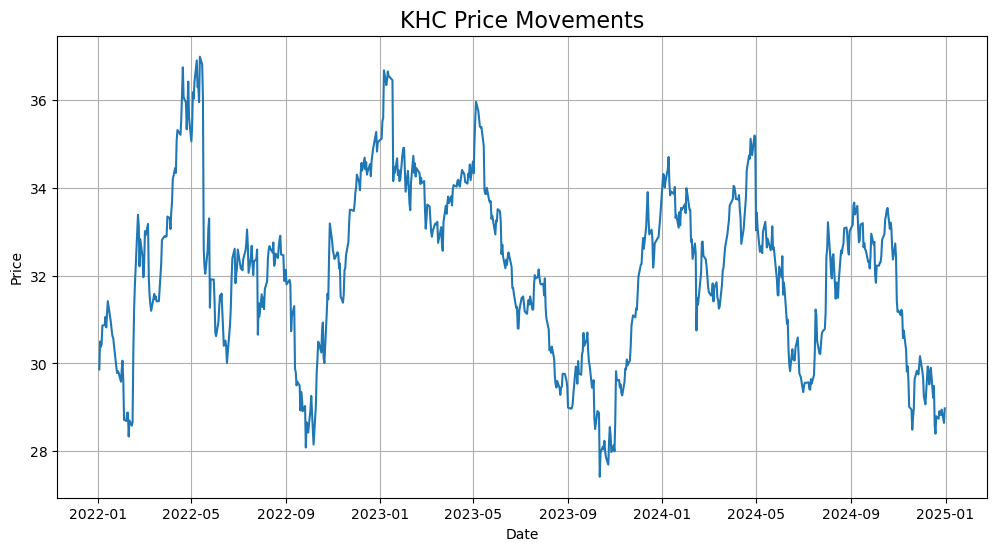

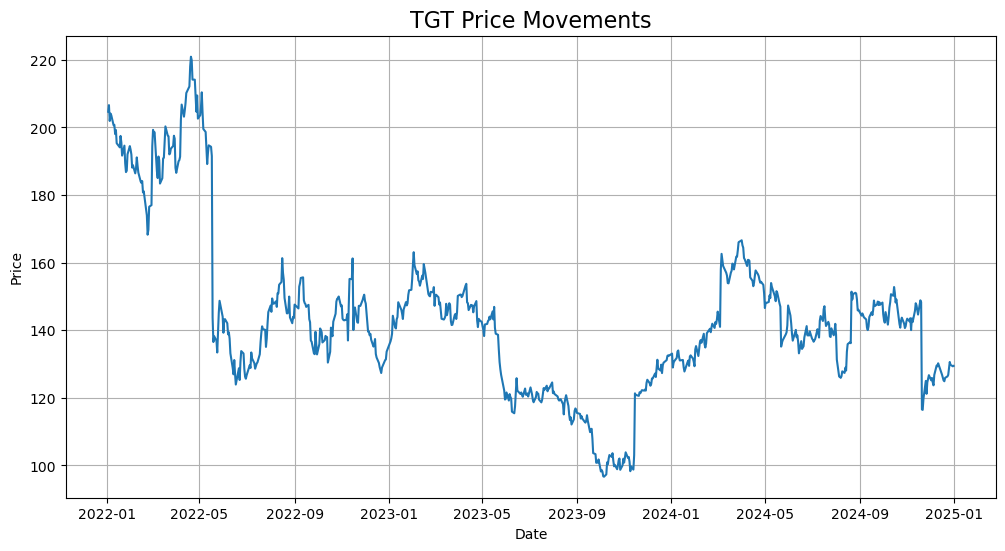

In [ ]:
# price movements for each stock

plt.figure(figsize=(12,6))
plt.plot(prices["KHC"])
plt.title("KHC Price Movements", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


plt.figure(figsize=(12,6))
plt.plot(prices["TGT"])
plt.title("TGT Price Movements", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


Beta: 4.6500035944635325


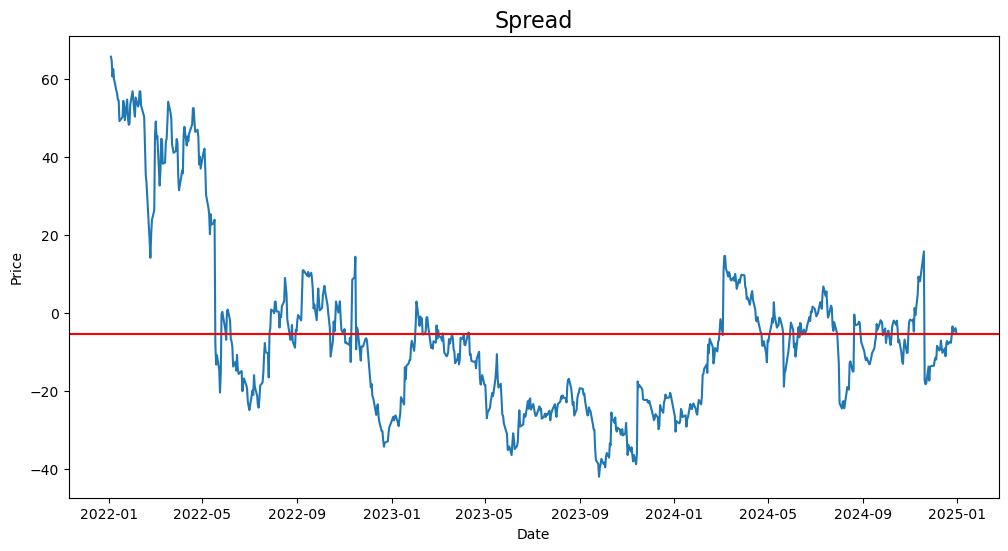

In [ ]:
# calculate the spread for two securities 
# TODO: possibly plot ratios

X = prices['KHC']
Y = prices['TGT']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
X = X['KHC']
beta = model.params['KHC']

print("Beta:", beta)

spread = Y - beta * X
plt.figure(figsize=(12,6))
plt.plot(spread)
plt.title("Spread", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.axhline(spread.mean(), color = 'red')
plt.show()


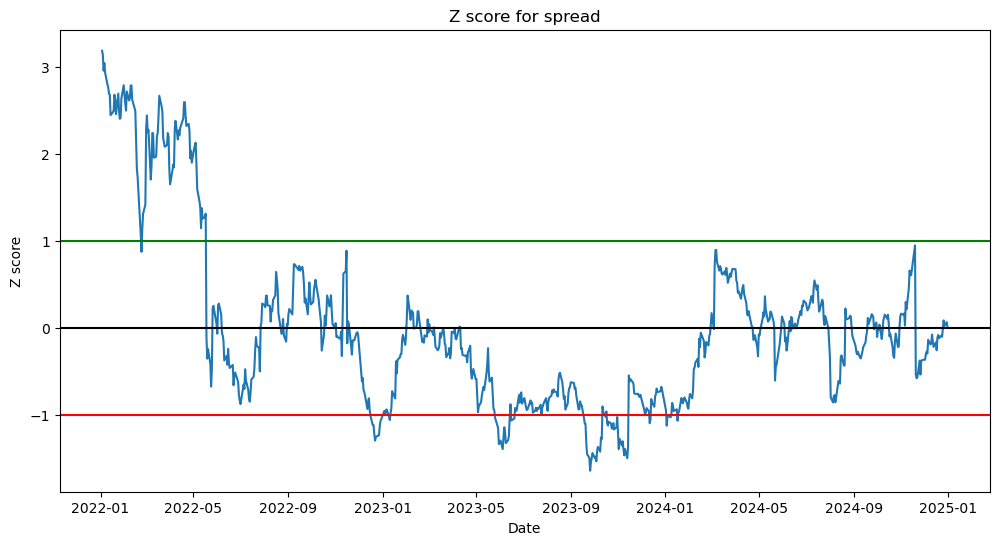

In [35]:
# calculate z scores for spreads

def zscore(series):
    return (series - series.mean()) / np.std(series)


plt.figure(figsize=(12,6))
plt.plot(zscore(spread))
plt.title("Z score for spread")
plt.xlabel("Date")
plt.ylabel("Z score")
plt.axhline(1, color = 'green')
plt.axhline(-1, color = 'red')
plt.axhline(0, color = 'black')
plt.show()
